In [1]:
import scanpy as sc
import scvi
import multigrate
import matplotlib.pyplot as plt
import gdown

In [2]:
%config InlineBackend.figure_format = 'retina'

# totalVI

## Load the dataset

In [3]:
gdown.download(
    'https://drive.google.com/uc?id=1oaVQ7LN5Oe8L3VPoTg_y1ak3PChLwm81',
    'gayoso2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1oaVQ7LN5Oe8L3VPoTg_y1ak3PChLwm81
To: /home/aomidi/theis/multigrate/example/gayoso2020-expressions.h5ad
464MB [02:33, 3.03MB/s] 


'gayoso2020-expressions.h5ad'

In [3]:
scrna = sc.read_h5ad('gayoso2020-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 30293 × 3999
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_types_colors', 'hvg', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
gdown.download(
    'https://drive.google.com/uc?id=1B2AR9zY6zacnFj9coQqkLmvT6UCGa9LF',
    'gayoso2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1B2AR9zY6zacnFj9coQqkLmvT6UCGa9LF
To: /home/aomidi/theis/multigrate/example/gayoso2020-proteins.h5ad
57.3MB [00:20, 2.82MB/s]


'gayoso2020-proteins.h5ad'

In [4]:
cite = sc.read_h5ad('gayoso2020-proteins.h5ad')
cite

AnnData object with n_obs × n_vars = 30293 × 110
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [5]:
# scvi needs one adata, so we merge rna and cite
adata = scrna
adata.obsm['proteins'] = cite.X

In [7]:
scvi.data.setup_anndata(adata, batch_key='batch', labels_key='cell_types', protein_expression_obsm_key='proteins')

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["cell_types"]                                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['proteins']                                
INFO     Generating sequential protein names                                                 
INFO     Successfully registered anndata object containing 30293 cells, 3999 vars, 4 batches,
         27 labels, and 110 proteins. Also registered 0 extra categorical covariates and 0   
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/scvi/data/_anndata.py:795: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = m

In [8]:
vae = scvi.model.TOTALVI(
    adata,
    latent_distribution="normal",
    n_layers_decoder=2
)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered protein expression in anndata contains unnormalized count  
         data.                                                                               


In [11]:
vae.train(n_epochs=100)

INFO     Training for 100 epochs.                                                            
INFO     KL warmup phase may exceed overall training phase.If your applications rely on      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 22719.75 iterations                                                   
Training...:   0%|          | 0/100 [00:00<?, ?it/s]

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/scvi/core/distributions/_negative_binomial.py:532: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...: 100%|██████████| 100/100 [03:36<00:00,  2.16s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  205 s. / 100 epochs                                                 


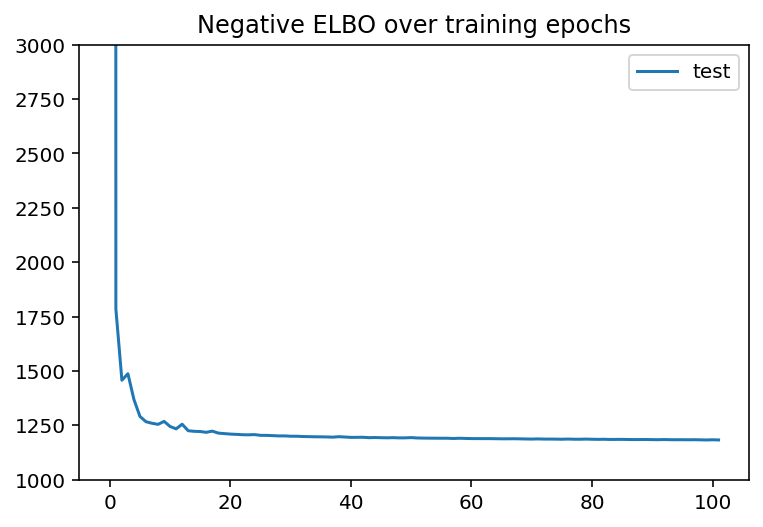

In [16]:
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1000, 3000)
plt.legend()

In [13]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered protein expression in anndata contains unnormalized count  
         data.                                                                               


In [14]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata)

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


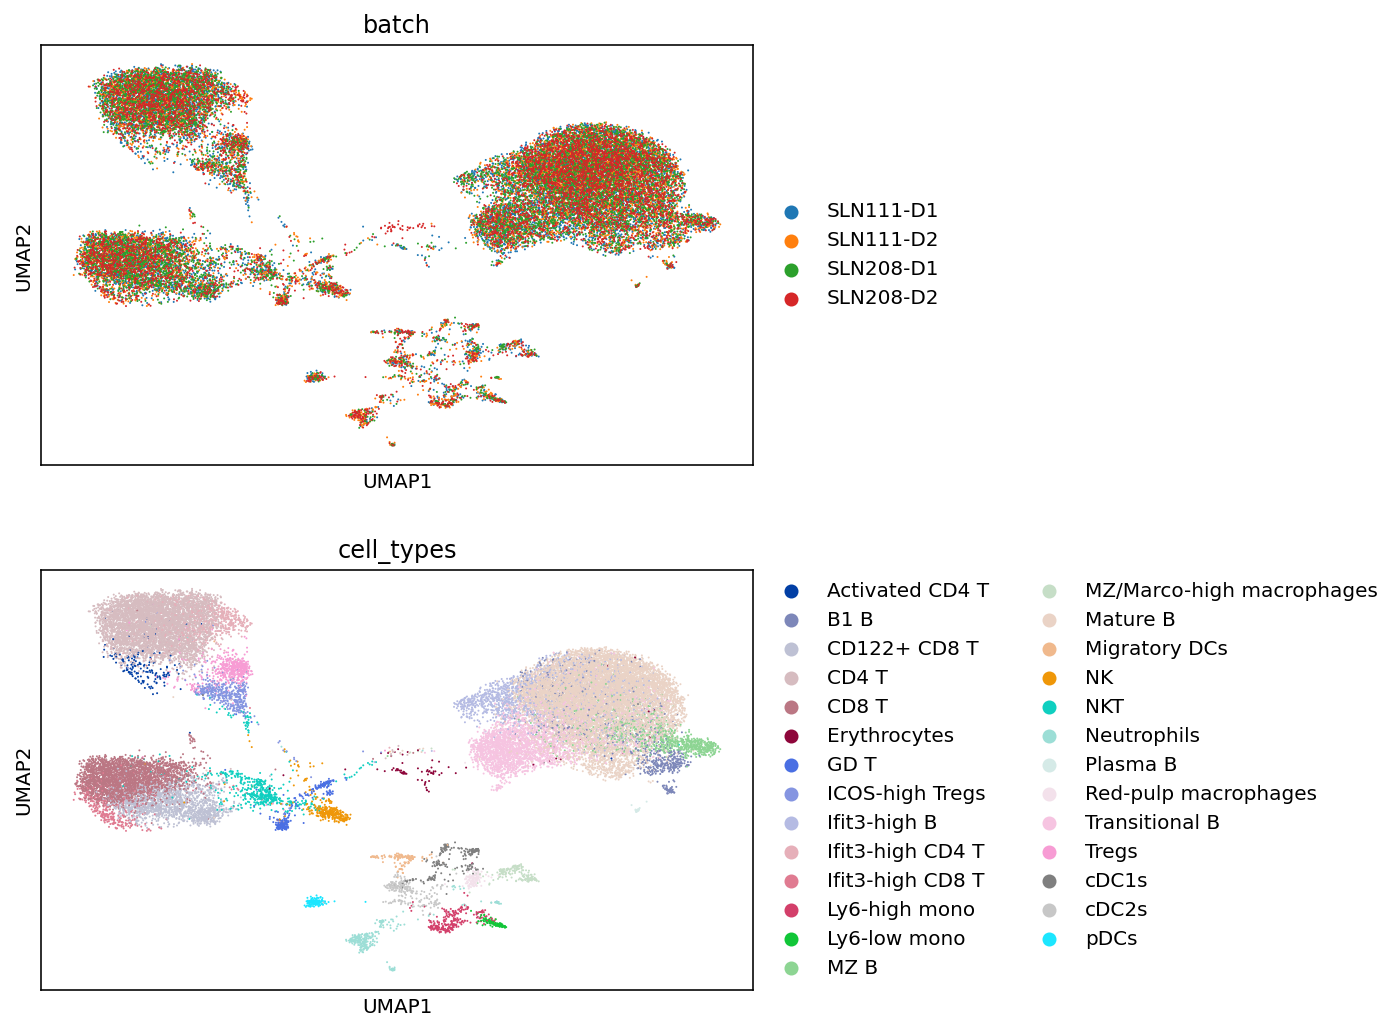

In [15]:
sc.pl.umap(adata, color=['batch', 'cell_types'], ncols=1)

In [18]:
sc.pp.pca(adata)
multigrate.metrics.metrics(
    adata, adata,
    batch_key='batch',
    label_key='cell_types',
    method='totalVI'
)

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Clustering...
ASW label/batch...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_catego

PCR batch...
Graph connectivity...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/multigrate-0.1.0-py3.7.egg/multigrate/metrics.py:548: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


ASW label...
NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.967026
PCR_batch,0.000000
graph_conn,0.983818
ASW_label,0.525729
NMI_cluster/label,0.738534
ARI_cluster/label,0.676738
isolated_label_silhouette,0.561285
